# AnyoneAI - Project II

# Making Predictions with NBA data

In our first project, we learned how to create our own datasets by using a public API, Python and Pandas. We're now going to explore how to make predictive models for regression and classification tasks using the Scikit Learn library

The goals of this project are:
- Learn how to define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Understand how Gradient Descent works by implementing a Linear Regressor in python

## 1. Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

But we're going to take a simplified approach, we'll try to use the data we already have to make the best estimator possible, and then we will analyze what went right and what could've gone wrong with our results.

### Analyzing our data

In [77]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import  RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder 
from numpy import array
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, SMOTENC
sns.set()


In [78]:
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")
data.to_csv("nba_player_dataset_project2.csv", index=False)

In [79]:
""" Reading the data from my local machine """
data = pd.read_csv("nba_player_dataset_project2.csv")

In [80]:
"""Replace NaN values with "Undrafted", and change the 'AGE' colum to a more usefull value """
data.DRAFT_NUMBER = data.DRAFT_NUMBER.fillna(value= 'Undrafted')
data.AGE = data.AGE.str[0:2].astype(int)
data

,PERSON_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
0,1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,2,20,134,18.4,7.2,5.1,0.8,0.4,0.5,2711280,23
1,203500,Steven Adams,Grizzlies,Center,211,120,New Zealand,1993-07-20,9,12,664,26.8,9.3,8.0,1.5,0.9,0.9,17073171,29
2,1628389,Bam Adebayo,Heat,Center,206,116,USA,1997-07-18,5,14,343,28.2,13.5,8.3,3.5,1.0,0.9,28103550,25
3,1630583,Santi Aldama,Grizzlies,Forward,211,98,Spain,2001-01-10,1,30,32,11.2,4.1,2.7,0.7,0.2,0.3,1994520,21
4,200746,LaMarcus Aldridge,Nets,Center,211,113,USA,1985-07-19,16,2,1076,33.7,19.1,8.1,1.9,0.7,1.1,2641691,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,1626153,Delon Wright,Wizards,Guard,196,84,USA,1992-04-26,7,20,411,20.9,7.2,3.2,3.0,1.2,0.4,8526316,30
425,201152,Thaddeus Young,Raptors,Forward,203,107,USA,1988-06-21,15,12,1085,29.3,12.8,5.8,1.8,1.4,0.4,14190000,34
426,1629027,Trae Young,Hawks,Guard,185,74,USA,1998-09-19,4,5,280,33.6,25.3,3.9,9.1,0.9,0.2,8326471,24
427,1630209,Omer Yurtseven,Heat,Center,211,125,Turkey,1998-06-19,1,Undrafted,56,12.6,5.3,5.3,0.9,0.3,0.4,1489065,24


Let's have another look at our previously generated dataset. 

1.1. Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary

C:\Users\marco\AppData\Local\Temp\ipykernel_4512\3358997100.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')


Text(0.5, 1.0, 'Correlation Heatmap')

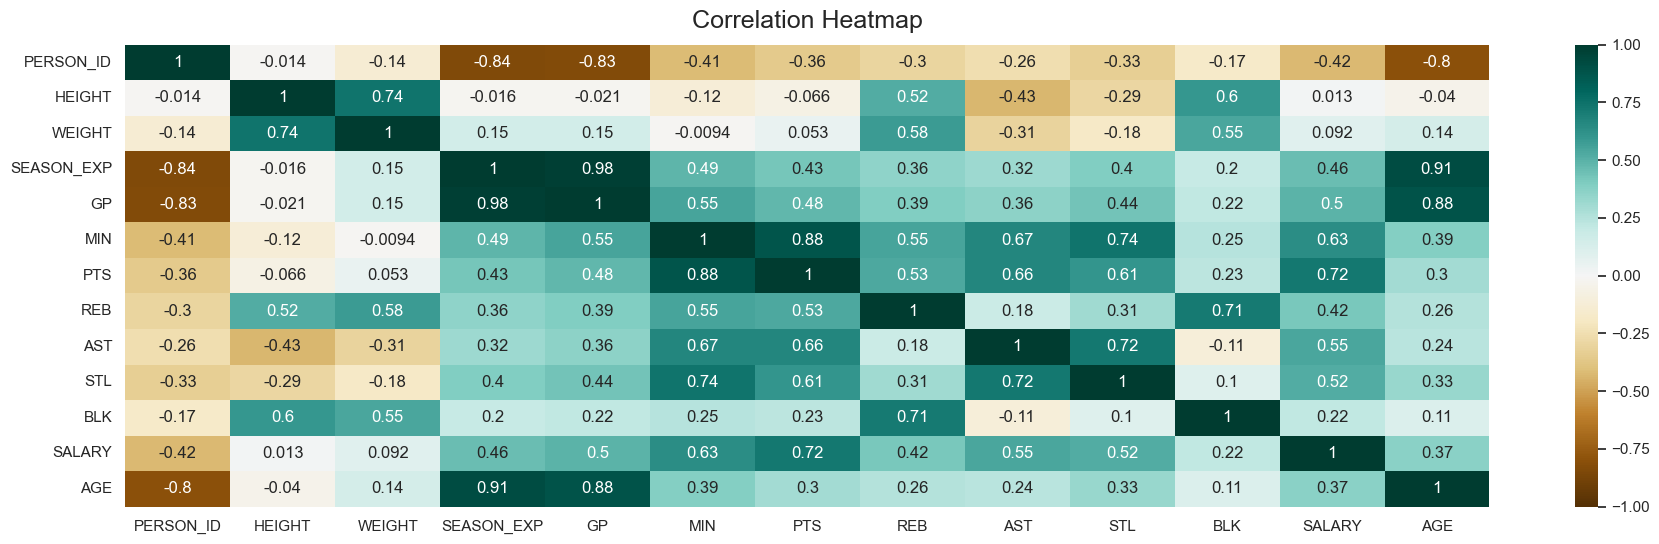

In [81]:
""" Plotting heatmap to see feaure correlation """
plt.figure(figsize=(22, 6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

Text(0.5, 1.0, 'Blockss vs Salary')

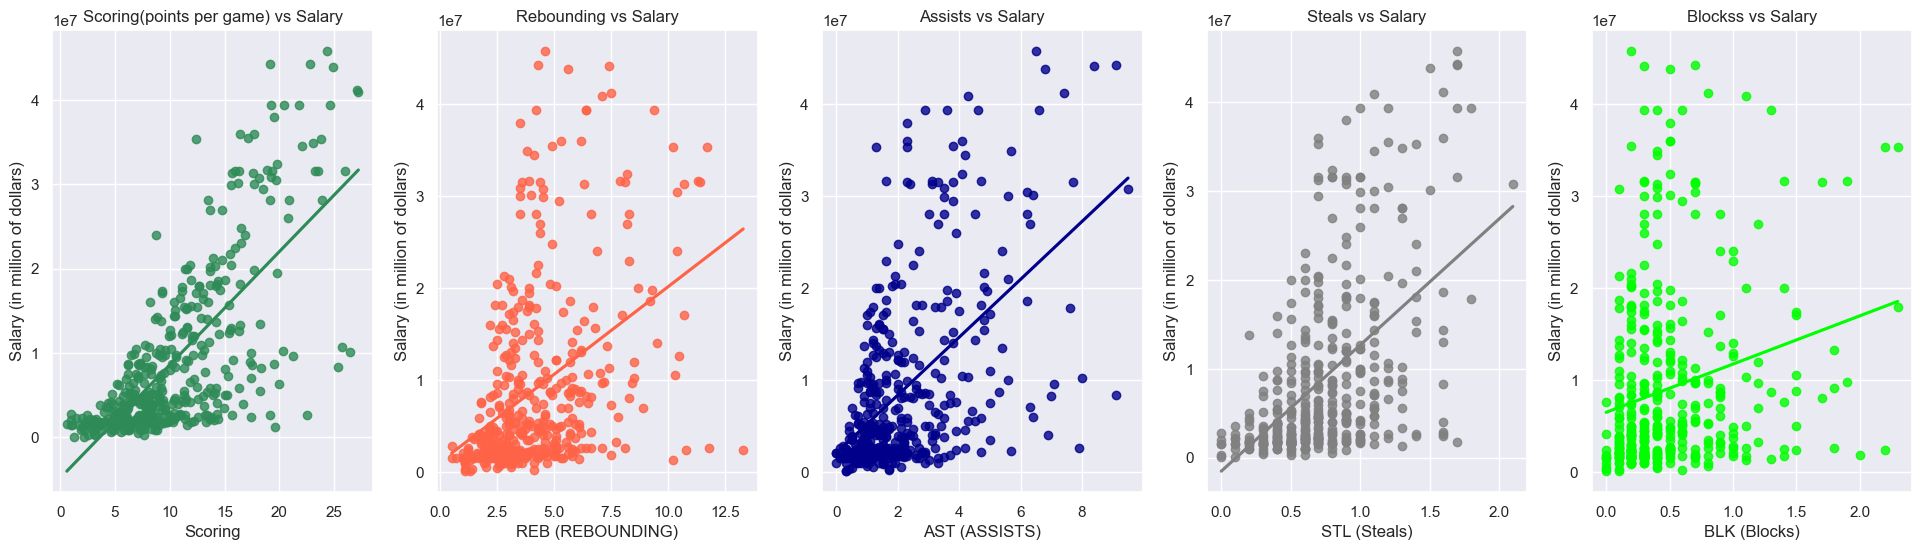

In [82]:
""" Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary """
fig, axes = plt.subplots(1, 5, figsize=(24, 6))
plot_1= sns.regplot(ax=axes[0], data=data, x='PTS', y='SALARY', color="seagreen", ci=None)
plot_2 =sns.regplot(ax=axes[1], data=data, x='REB', y='SALARY', color="tomato", ci=None)
plot_3 =sns.regplot(ax=axes[2], data=data, x='AST', y='SALARY', color="darkblue", ci=None)
plot_4 =sns.regplot(ax=axes[3], data=data, x='STL', y='SALARY', color="grey", ci=None)
plot_5 =sns.regplot(ax=axes[4], data=data, x='BLK', y='SALARY', color="lime",ci=None)
plot_1.set(xlabel='Scoring', ylabel='Salary (in million of dollars)')
plot_2.set(xlabel='REB (REBOUNDING)', ylabel='Salary (in million of dollars)')
plot_3.set(xlabel='AST (ASSISTS)', ylabel='Salary (in million of dollars)')
plot_4.set(xlabel='STL (Steals)', ylabel='Salary (in million of dollars)')
plot_5.set(xlabel='BLK (Blocks)', ylabel='Salary (in million of dollars)')
axes[0].set_title('Scoring(points per game) vs Salary')
axes[1].set_title('Rebounding vs Salary')
axes[2].set_title('Assists vs Salary')
axes[3].set_title('Steals vs Salary')
axes[4].set_title('Blockss vs Salary')

1.2. What can we say about these distributions?

In [83]:
""" In the 'Correlation Heatmap' plot the values closer to zero means there is no linear correlation between the two variables. The closer to 1 the correlation is the more positively correlated they are, a correlation closer to -1
means one variable will decrease as the other increases and correlation coser to positive 1 means that as one variable increase so does the other.
We can also see in the regression plots that of all the stats 'PTS vs Salary' have the strongest colleration and a positive trend, meaning that as the player scores more points there is a higher probability of having a higher salary, 
in second comes 'AST vs Salary' with a positve trend as well but less steep, followed by 'STL vs Salary' with a positive trend and a similar correlation as 'AST vs Salary',
and second-last comes 'REB vs Salay' with a positve trend but a lesser impact on salary', and in last place in terms of correlation to salary comes 'BLK vs Salary', with the lesat impact on salary."""

" In the 'Correlation Heatmap' plot the values closer to zero means there is no linear correlation between the two variables. The closer to 1 the correlation is the more positively correlated they are, a correlation closer to -1\nmeans one variable will decrease as the other increases and correlation coser to positive 1 means that as one variable increase so does the other.\nWe can also see in the regression plots that of all the stats 'PTS vs Salary' have the strongest colleration and a positive trend, meaning that as the player scores more points there is a higher probability of having a higher salary, \nin second comes 'AST vs Salary' with a positve trend as well but less steep, followed by 'STL vs Salary' with a positive trend and a similar correlation as 'AST vs Salary',\nand second-last comes 'REB vs Salay' with a positve trend but a lesser impact on salary', and in last place in terms of correlation to salary comes 'BLK vs Salary', with the lesat impact on salary."

### Splitting the Dataset

1.3. Split the dataset into train and testing sets. Use the Sklearn function for train/test splitting. Make sure to set the random state for reproducibility.

**Note:** Before using scikit-learn `train_test_split()`, separate your dataframe into features and labels. Assign your features to `X` variable and labels to `y`.

In [84]:
# TODO: Put here your features
X = data[['PERSON_ID', 'PLAYER_NAME', 'TEAM_NAME', 'POSITION', 'HEIGHT', 'WEIGHT','COUNTRY', 'BIRTHDATE', 'SEASON_EXP', 'DRAFT_NUMBER', 'GP', 'MIN','PTS', 'REB', 'AST', 'STL', 'BLK', 'AGE']]
# TODO: Put here your labels
y = data['SALARY']

# TODO: Now use train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2611,shuffle=True)

*Don't change anything in this cell, just make it run correctly*

In [85]:
if X.SEASON_EXP[322] == 7 and y[255] == 1517981:
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

if X.shape == (429, 18) and y.shape == (429,):
  print('Success!')
else:
  raise ValueError('Your features/labels shape is incorrect, please review your code')


Success!
Success!


### Baseline Model and Evaluation Metric

In every project, we need a baseline model that implements a very simple algorithm or heuristic so we can compare our results with it. 
In this case, we could create a function that always returns the average player salary, evaluate that, and then compare the result with our modeling to see if we are improving. 

We need an evaluation metric to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better. 

For this particular problem, we will always round the value, as we don't need decimals for this task.

1.4. Create a Baseline model class that implements  fit() and predict() methods. As this model will not consider any other variable, the fit method should only receive a list of all players salaries. The predict method should receive and iterable and return a numpy array with the same length but every element should have the same value (the average salary)

In [86]:
class BaselineModel():
  """
  A baseline model that always returns the same value, the mean of the 
  players salary in the train data

  f(x) = mean(train_labels)
   
  """
  def __init__(self):
    self.w0 = 0
    self.w1 = 0

  
  def fit(self, df_train):
    """
    Fit the training data. 
    
    Parameters
    ----------
    y_train: Union[pd.Series, np.ndarray]
        a pandas series or numpy array containing salary information
    """
    self.w0 = np.mean(df_train)
    return self.w0
      
  
  def predict(self, df_test):
    """
    Predict salaries 
    
    Parameters
    ----------
    X: Union[pd.DataFrame, pd.Series, np.ndarray]
        a pandas series, dataframe or numpy array with the 
        
    Returns
    -------
    np.ndarray
        a numpy array of the same length as X, with all elements equal to 
        the mean salary calculated in fit()
    """
    predict_array_shape = np.arange(len(df_test)).T
    self.w1 = np.full_like(predict_array_shape, self.w0)
    return self.w1
      

1.5. Evaluate the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn (round the result)

In [87]:
baseline = BaselineModel()
y_baseline_predicted = baseline.fit(y_train) # recives the list of player salaries
y_baseline_predicted = baseline.predict(X_test).round()
MAE_baseline = mean_absolute_error(y_test, y_baseline_predicted )
MAE_baseline

7759882.011627907

### Regression with a single variable

You're now going to start modeling data. We will start with a really simple approach, selecting just one variable, and doing a regression to see if we improve upon our baseline.


1.6. Select the variable you think would provide the best fit. Perform feature scaling on this variable using a Sklearn scaler.

In [88]:
scaler_single_var = StandardScaler()
scaler_single_var .fit(X_train['PTS'].values.reshape(-1, 1))
X_train['PTS'] = scaler_single_var.transform(X_train['PTS'].values.reshape(-1, 1))
X_test['PTS'] = scaler_single_var.transform(X_test['PTS'].values.reshape(-1, 1))

1.7. Train a model with [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) from Sklearn using the default parameters. Evaluate the model's performance on the test set using the selected metric.

In [89]:
sgd_model_single_var = SGDRegressor(random_state=2611)
sgd_model_single_var.fit(X_train[['PTS']], y_train) # Double brackets to pass it as a dataframe or use values.reshape(-1, 1)
y_single_var_predicted = sgd_model_single_var.predict(X_test[['PTS']])
MAE_single_var = mean_absolute_error(y_test, y_single_var_predicted)
MAE_single_var

5157214.2603347525

1.8. Read the Sklearn documentation, and write a function that tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. For each combination of parameters, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination, finally select the one that has the best MAE (meaning the lowest number) and print the combination and the MAE.

In [90]:
def search_best_hyperparameters_SGDRegressor_singlevar(max_iter, eta0, alpha, dfx_train, dfx_test, dfy_train, dfy_test,column_name):
  
  """
  A funtion that looks for the best hyperparameters of an SGDRegressor out of a given list
  of values
  """
  """
  Parameters
    ----------
    max iter: The maximum number of passes over the training data (aka epochs). It only impacts the behavior in the fit method,
               and not the partial_fit method, default=1000.
    eta0: The initial learning rate for the 'constant', 'invscaling' or 'adaptive' schedules. The default value is 0.01.
    alpha: Constant that multiplies the regularization term. The higher the value, the stronger the regularization.
           Also used to compute the learning rate when set to learning_rate is set to 'optimal' default=0.0001.
    dfx_train: X_train dataframe of the splitted X dataframe (features)
    dfx_test: X_test dataframe of the splitted X dataframe (features)
    dfy_train: y_train dataframe of the splitted y dataframe (labels)
    dfy_train: y_test dataframe of the splitted y dataframe (labels)
    columns_name: Name of the silgle column to fit and transform in string format eg. 'PTS'
    """
  result_singlevar = {
    "hyperparameters": {"max_iter": None, "eta0": None,  "alpha": None}, 
    "mae": 0
  }
  # Complete your code here
  MAE_list = []
  for iter in max_iter:
    for initial_lr in eta0:
      for alph in alpha:
        SGDRegressor_single_var = SGDRegressor(max_iter=iter, eta0=initial_lr,  alpha=alph, random_state=2611)
        SGDRegressor_single_var.fit(dfx_train[[column_name]], dfy_train) # Double brackets to pass it as a dataframe or use values.reshape(-1, 1)
        y_single_var_predicted = SGDRegressor_single_var.predict(dfx_test[[column_name]])
        MAE_hyperparameter = round(mean_absolute_error(dfy_test, y_single_var_predicted), 0)
        MAE_list.append(MAE_hyperparameter)
        if MAE_hyperparameter == min(MAE_list):
          result_singlevar['hyperparameters']['max_iter'] = iter
          result_singlevar['hyperparameters']['eta0'] = initial_lr
          result_singlevar['hyperparameters']['alpha'] = alph
          result_singlevar['mae'] = MAE_hyperparameter
  """"
  Returns
    -------
    dictionary
        a dictionary with the  best combination of hyperparameters out of the given lists of values for each parameter.
    """
  return result_singlevar

In [91]:
# list of hyperparameters values
max_iter = [1000, 10000, 100000, 1000000]
eta0 = [0.0001, 0.001, 0.01, 0.1]
alpha = [0.00001, 0.0001]
result_singlevar = search_best_hyperparameters_SGDRegressor_singlevar(max_iter, eta0, alpha, X_train, X_test, y_train, y_test, "PTS")
print(result_singlevar)

c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint2-Hzs07fFS-py3.8\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint2-Hzs07fFS-py3.8\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


{'hyperparameters': {'max_iter': 1000000, 'eta0': 0.1, 'alpha': 0.0001}, 'mae': 5062847.0}


1.9. Compare the results of the baseline, the SGDRegressor with default parameters and the one with the best combination of hyperparameters you could find. (replace variables with the ones you used)

In [92]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {MAE_baseline}")
print(f"Default SGDRegressor: {MAE_single_var}")
print(f"Best SGDRegressor single var: {result_singlevar['mae']}")

Mean Absolute Error for each model:
Baseline: 7759882.011627907
Default SGDRegressor: 5157214.2603347525
Best SGDRegressor single var: 5062847.0


### Multivariable Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Create a copy of the dataset generated in the first project that only has the following columns (and player id as an index) and name it mv_regression_df:

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "SALARY"]

In [93]:
# TODO: Complete here
mv_regression_df = data[["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "SALARY"]].copy(deep=True)

*Don't change anything in this cell, just make it run correctly*

In [94]:
if mv_regression_df.shape == (429, 8):
  print('Success!')
else:
  raise ValueError('The shape is incorrect, please review your function')

Success!


#### Feature Engineering

1.11. Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted
       
Create a new column named DRAFT using these 4 categories. Drop the draft number column.

In [95]:
mv_regression_df.DRAFT_NUMBER = mv_regression_df.DRAFT_NUMBER.replace('Undrafted',99) # Creates a bin limit for the last category, 99 places it last
mv_regression_df.DRAFT_NUMBER = mv_regression_df.DRAFT_NUMBER.astype(int)
bins = [0,15,30,60,99] # Creates upper and lower limits of each bin
categories = ['firstround_lottery', 'firstround_non_lottery', 'second_round', 'undrafted'] # Category name of each bin
mv_regression_df['DRAFT']= pd.cut(mv_regression_df['DRAFT_NUMBER'], bins, labels=categories) # pd.cur creates the bins categories given the 'bins' and 'ctegories' lists
mv_regression_df = mv_regression_df.drop(columns=['DRAFT_NUMBER'])
mv_regression_df


,PTS,REB,AST,BLK,SEASON_EXP,POSITION,SALARY,DRAFT
0,7.2,5.1,0.8,0.5,2,Forward,2711280,firstround_non_lottery
1,9.3,8.0,1.5,0.9,9,Center,17073171,firstround_lottery
2,13.5,8.3,3.5,0.9,5,Center,28103550,firstround_lottery
3,4.1,2.7,0.7,0.3,1,Forward,1994520,firstround_non_lottery
4,19.1,8.1,1.9,1.1,16,Center,2641691,firstround_lottery
...,...,...,...,...,...,...,...,...
424,7.2,3.2,3.0,0.4,7,Guard,8526316,firstround_non_lottery
425,12.8,5.8,1.8,0.4,15,Forward,14190000,firstround_lottery
426,25.3,3.9,9.1,0.2,4,Guard,8326471,firstround_lottery
427,5.3,5.3,0.9,0.4,1,Center,1489065,undrafted


*Don't change anything in this cell, just make it run correctly*

In [96]:
if mv_regression_df["DRAFT"].iloc[34] == 'firstround_lottery' and mv_regression_df["DRAFT"].iloc[105] == 'second_round':
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

Success!


1.12. Encode the categorical features: DRAFT, POSITION

In [97]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', categories='auto')
encoder_draft_position_df = pd.DataFrame(onehot_encoder.fit_transform(mv_regression_df[['DRAFT', 'POSITION']]).toarray())
mv_regression_df = mv_regression_df.join(encoder_draft_position_df)
mv_regression_df = mv_regression_df.rename(columns = {0:'DRAFT_firstround_lottery', 1:'DRAFT_firstround_non_lottery',2:'DRAFT_second_round', 3:'DRAFT_undrafted',
                                                      4:'POSITION_Center', 5:'POSITION_Forward', 6:'POSITION_Guard' })
mv_regression_df = mv_regression_df.drop(columns=['DRAFT' , 'POSITION'])
mv_regression_df




,PTS,REB,AST,BLK,SEASON_EXP,SALARY,DRAFT_firstround_lottery,DRAFT_firstround_non_lottery,DRAFT_second_round,DRAFT_undrafted,POSITION_Center,POSITION_Forward,POSITION_Guard
0,7.2,5.1,0.8,0.5,2,2711280,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,9.3,8.0,1.5,0.9,9,17073171,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,13.5,8.3,3.5,0.9,5,28103550,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.1,2.7,0.7,0.3,1,1994520,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,19.1,8.1,1.9,1.1,16,2641691,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,7.2,3.2,3.0,0.4,7,8526316,0.0,1.0,0.0,0.0,0.0,0.0,1.0
425,12.8,5.8,1.8,0.4,15,14190000,1.0,0.0,0.0,0.0,0.0,1.0,0.0
426,25.3,3.9,9.1,0.2,4,8326471,1.0,0.0,0.0,0.0,0.0,0.0,1.0
427,5.3,5.3,0.9,0.4,1,1489065,0.0,0.0,0.0,1.0,1.0,0.0,0.0


*Don't change anything in this cell, just make it run correctly*

In [98]:
if mv_regression_df["DRAFT_firstround_non_lottery"].iloc[134] == 1 and mv_regression_df["POSITION_Forward"].iloc[205] == 0:
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

Success!


#### Modeling

1.13. Split the dataset into train and test. 


**Note 1:** Before using scikit-learn `train_test_split()`, separate your dataframe into features and labels. Assign your features to `X` variable and labels to `y`.

**Note 2:** Remember to drop `DRAFT_NUMBER` column if you haven't done that before

In [99]:
# TODO: Put here your features
X = mv_regression_df.drop(columns=['SALARY'])
# TODO: Put here your labels
y = mv_regression_df['SALARY']

# TODO: Now use train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2611,shuffle=True)

*Don't change anything in this cell, just make it run correctly*

In [100]:
if X.BLK.iloc[353] == 0.1 and y.iloc[400] == 8729020:
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

Success!


1.14. Perform feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number (which we will tackle next).

In [101]:
scaler = StandardScaler()
X_train[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]] = scaler.fit_transform(X_train[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]])
X_test[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]] = scaler.fit_transform(X_test[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]])
X_train

,PTS,REB,AST,BLK,SEASON_EXP,DRAFT_firstround_lottery,DRAFT_firstround_non_lottery,DRAFT_second_round,DRAFT_undrafted,POSITION_Center,POSITION_Forward,POSITION_Guard
204,0.772306,0.766591,-0.263277,-0.665898,-0.673172,0.0,1.0,0.0,0.0,0.0,1.0,0.0
410,0.423548,3.090209,-0.983308,4.062942,1.076055,0.0,0.0,1.0,0.0,1.0,0.0,0.0
138,0.384797,3.508461,-0.563290,4.062942,0.826165,0.0,1.0,0.0,0.0,1.0,0.0,0.0
296,-1.010234,-1.092304,0.036736,-0.665898,-0.173393,1.0,0.0,0.0,0.0,0.0,0.0,1.0
47,-1.746501,-1.371138,-0.983308,-1.138782,-1.172950,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
134,-0.273968,0.906008,-0.743298,1.225638,1.825723,0.0,1.0,0.0,0.0,0.0,1.0,0.0
97,0.171668,-0.906414,-0.023266,-0.902340,0.576276,0.0,0.0,0.0,1.0,0.0,0.0,1.0
53,-1.126487,0.069505,-1.043311,0.279870,-0.173393,0.0,1.0,0.0,0.0,1.0,0.0,0.0
82,-0.487097,-0.766997,-0.143272,-0.665898,-1.172950,0.0,1.0,0.0,0.0,0.0,0.0,1.0


1.15. Write a function to train a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [102]:
def search_best_hyperparameters_SGDRegressor_multivar(max_iter, eta0, alpha, dfx_train, dfx_test, dfy_train, dfy_test):
  result_multivar = {
    "hyperparameters": {"max_iter": None, "eta0": None, "alpha": None }, 
    "mae": 0
  }
  """
    A funtion that looks for the best hyperparameters of an SGDRegressor out of a given list
    of values
  """
  """
    Parameters
    ----------
    max iter: The maximum number of passes over the training data (aka epochs). It only impacts the behavior in the fit method,
               and not the partial_fit method, default=1000.
    eta0: The initial learning rate for the 'constant', 'invscaling' or 'adaptive' schedules. The default value is 0.01.
    alpha: Constant that multiplies the regularization term. The higher the value, the stronger the regularization.
           Also used to compute the learning rate when set to learning_rate is set to 'optimal' default=0.0001.
    dfx_train: X_train dataframe of the splitted X dataframe (features)
    dfx_test: X_test dataframe of the splitted X dataframe (features)
    dfy_train: y_train dataframe of the splitted y dataframe (labels)
    dfy_train: y_test dataframe of the splitted y dataframe (labels)
    """
  # Complete your code here
  MAE_list = []
  for iter in max_iter:
    for initial_lr in eta0:
      for alph in alpha:
        SGDRegressor_multi_var = SGDRegressor(max_iter=iter, eta0=initial_lr, alpha=alph, random_state=2611)
        SGDRegressor_multi_var.fit(dfx_train, dfy_train)
        y_multi_var_predicted = SGDRegressor_multi_var.predict(dfx_test)
        MAE_hyperparameter = round(mean_absolute_error(dfy_test, y_multi_var_predicted), 0)
        MAE_list.append(MAE_hyperparameter)
        if MAE_hyperparameter == min(MAE_list):
          result_multivar['hyperparameters']['max_iter'] = iter
          result_multivar['hyperparameters']['eta0'] = initial_lr
          result_multivar['hyperparameters']['alpha'] = alph
          result_multivar['mae'] = MAE_hyperparameter
  """"
  Returns
    -------
    dictionary
        a dictionary with the  best combination of hyperparameters out of the given lists of values for each parameter.
    """
  return result_multivar

In [103]:
# Example list of hyperparameters values
max_iter = [1000,10000, 100000, 1000000]
eta0 = [0.0001, 0.001, 0.01, 0.1]
alpha = [0.00001, 0.0001]
result_multivar = search_best_hyperparameters_SGDRegressor_multivar(max_iter, eta0, alpha, X_train, X_test, y_train, y_test)
print(result_multivar)

c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint2-Hzs07fFS-py3.8\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint2-Hzs07fFS-py3.8\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint2-Hzs07fFS-py3.8\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint2-Hzs07fFS-py3.8\lib\site-packag

{'hyperparameters': {'max_iter': 1000, 'eta0': 0.0001, 'alpha': 0.0001}, 'mae': 4897475.0}


1.16. How did the model performed compared to our univariate models? 

In [104]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {MAE_baseline}")
print(f"Default SGDRegressor: {MAE_single_var}")
print(f"Best SGDRegressor: {result_singlevar['mae']}")
print(f"Best SGDRegressor Multivariable: {result_multivar['mae']}")

Mean Absolute Error for each model:
Baseline: 7759882.011627907
Default SGDRegressor: 5157214.2603347525
Best SGDRegressor: 5062847.0
Best SGDRegressor Multivariable: 4897475.0


### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, let's try with a very used algorithm, a Decision Tree.



1.17. Create new model using [DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) from scikit learn. We will use again all variables, and try different configuration for the following hyperparameters:

- max_depth
- min_samples_leaf
- max_features

These are all regularization hyperparameters for this algorithm. Read the documentation to get a better grasp of what each one does.

In [105]:
# TODO: Put here your features
mv_regression_df2 = mv_regression_df.copy(deep=True)
mv_regression_df2['AGE'] = data['AGE']
X = mv_regression_df2.drop(columns=['SALARY'])
# TODO: Put here your labels
y = mv_regression_df2['SALARY']

# TODO: Now use train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2611,shuffle=True)

In [106]:
scaler = StandardScaler()
X_train[["PTS", "REB", "AST", "BLK", "SEASON_EXP", "AGE"]] = scaler.fit_transform(X_train[["PTS", "REB", "AST", "BLK", "SEASON_EXP", "AGE"]])
X_test[["PTS", "REB", "AST", "BLK", "SEASON_EXP", "AGE"]] = scaler.fit_transform(X_test[["PTS", "REB", "AST", "BLK", "SEASON_EXP", "AGE"]])

In [107]:
def search_best_hyperparameters_DecisionTreeRegressor(max_depth, min_samples_leaf, max_features, dfx_train, dfx_test, dfy_train, dfy_test):
  result_decisionTreeRegressor = {
    "hyperparameters": {"max_depth": None, "min_samples_leaf": None, "max_features": None }, 
    "mae": 0
  }
  """
    A funtion that looks for the best hyperparameters of an DecisionTreeRegressor out of a given range
    of values
  """
  """
    Parameters
    ----------
    max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until 
               all leaves contain less than min_samples_split samples, default=None.
    min_samples_leaf: The minimum number of samples required to be at a leaf node, default=1.
    max_features: The number of features to consider when looking for the best split, default=None .
    dfx_train: X_train dataframe of the splitted X dataframe (features)
    dfx_test: X_test dataframe of the splitted X dataframe (features)
    dfy_train: y_train dataframe of the splitted y dataframe (labels)
    dfy_train: y_test dataframe of the splitted y dataframe (labels)
    """
  # Complete your code here
  MAE_list = []
  for depth in max_depth:
    for sample in min_samples_leaf:
      for feature in max_features:
        dt_model = DecisionTreeRegressor(max_depth=depth,min_samples_leaf=sample, max_features=feature, random_state=2611)
        dt_model.fit(dfx_train, dfy_train)
        y_single_var_predicted = dt_model.predict(dfx_test)
        MAE_hyperparameter = round(mean_absolute_error(dfy_test, y_single_var_predicted), 0)
        MAE_list.append(MAE_hyperparameter)
        if MAE_hyperparameter == min(MAE_list):
          result_decisionTreeRegressor['hyperparameters']['max_depth'] = depth
          result_decisionTreeRegressor['hyperparameters']['min_samples_leaf'] = sample
          result_decisionTreeRegressor['hyperparameters']['max_features'] = feature
          result_decisionTreeRegressor['mae'] = MAE_hyperparameter

  """"
  Returns
    -------
    dictionary
        a dictionary with the  best combination of hyperparameters out of the given lists of values for each parameter.
    """
  return result_decisionTreeRegressor

In [108]:
# List of hyperparameter example values
max_depth = range(5,50)  
min_samples_leaf = range(1,50)  
max_features = range(5,15) 
result_decisionTreeRegressor = search_best_hyperparameters_DecisionTreeRegressor(max_depth, min_samples_leaf, max_features, X_train, X_test, y_train, y_test)
print(result_decisionTreeRegressor)

{'hyperparameters': {'max_depth': 6, 'min_samples_leaf': 1, 'max_features': 12}, 'mae': 2766252.0}


1.18. Compare the results obtained with the best decision tree model against the baseline, default and the best params sgd regressors-

In [109]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {MAE_baseline}")
print(f"Default SGDRegressor: {MAE_single_var}")
print(f"Best SGDRegressor: {result_singlevar['mae']}")
print(f"Best SGDRegressor Multivariable: {result_multivar['mae']}")
print(f"Best DecisionTreeRegressor: {result_decisionTreeRegressor['mae']}")

Mean Absolute Error for each model:
Baseline: 7759882.011627907
Default SGDRegressor: 5157214.2603347525
Best SGDRegressor: 5062847.0
Best SGDRegressor Multivariable: 4897475.0
Best DecisionTreeRegressor: 2766252.0


### Analyzing our results

Based on what you found, and what you read about players salaries above, answer the following: 

1.19. Which kind of model worked better in this dataset, linear or non linear models? Do you have any hypothesis about why? 

In [110]:
""" The non linear DecisionTreeRegressor model worked much better than the linear SGDRegressor model in this dataset,
 The reason is that the salary depends on variables which at the same time depend on other variable hence the degree of the non linearity, 
 so breaking the dataset into smaller subsets or desicion nodes will result in a better prediction."""

' The non linear DecisionTreeRegressor model worked much better than the linear SGDRegressor model in this dataset,\n The reason is that the salary depends on variables which at the same time depend on other variable hence the degree of the non linearity, \n so breaking the dataset into smaller subsets or desicion nodes will result in a better prediction.'

1.20. Is there something else we could do to improve our results if wanted to make a more accurate model?

In [111]:
"""I added 'AGE' as a feature to the DecisionTreeRegressor model and it improved noticeably, I would Hotcode the 'TEAM_NAME' column and add it to the model dataframe, 
   then run the Best_Hyperparameter funtion to make the model more accurate, A RandomForestRegressor algorithm could also be used to improve accuracy"""

"I added 'AGE' as a feature to the DecisionTreeRegressor model and it improved noticeably, I would Hotcode the 'TEAM_NAME' column and add it to the model dataframe, \n   then run the Best_Hyperparameter funtion to make the model more accurate, A RandomForestRegressor algorithm could also be used to improve accuracy"

## 2. Predicting players All-NBA selections

In this section we're going to try to solve a different question:

Can we train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season? This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, so we're training our first classifier model to solve this problem.

Consider that:

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game). 
- You're trying to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season (you're not going to consider if the players got to the NBA finals for example). 
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

### Analyzing the data

To do this task, you're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1983 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.


2.1. Load the dataset "all_nba_1983_2017_dataset.csv" from disk, look at the data inside it and print:
- number of rows
- number of seasons
- number of unique players
- number of all-nba selections vs non selected 

In [112]:
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1983_2017_dataset.csv", index_col=0)
all_nba_df.to_csv("all_nba_teams_dataset_project2.csv", index=False)

In [113]:
all_nba_df = pd.read_csv("all_nba_teams_dataset_project2.csv")

In [114]:
print(f' number of rows {len(all_nba_df)}')
print(f' number of seasons {len(all_nba_df.season_start.unique())}')
print(f' number of unique players {len(all_nba_df.player.unique())}')
print(f' number of all-nba selections {all_nba_df.all_nba.value_counts()[1]} vs non selected {all_nba_df.all_nba.value_counts()[0]}')

 number of rows 14825
 number of seasons 39
 number of unique players 2701
 number of all-nba selections 496 vs non selected 14329


### Splitting the dataset

2.2. Split the dataset in training and test sets. Make sure to keep the distribution of values in the target variable.

Use columns: 'team', 'games', 'games_started', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'.

**Note:** Assign your features to `X` variable and labels to `y`.



In [115]:
# TODO: Put here your features
X = all_nba_df[['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc','2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']]
# TODO: Put here your labels
y = all_nba_df['all_nba']

# TODO: Now use train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2611,shuffle=True)

*Don't change anything in this cell, just make it run correctly*

In [116]:
if X.shape == (14825, 15) and y.shape == (14825,):
  print('Success!')
else:
  raise ValueError('Your features/labels shape is incorrect, please review your code')


Success!


### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. For this you're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

2.3. Let's start with a simple test. What accuracy would we get if we had a baseline model that always predicted 0 (player not selected to all nba)?

In [117]:
class BaselineModel_lr():
  """
  A baseline model that always returns the same value, the mean of the 
  players salary in the train data

  f(x) = 0
   
  """
  def __init__(self):
    self.w0 = 0
    self.w1 = 0

  
  def fit(self, df_train):
    """
    Fit the training data. 
    
    Parameters
    ----------
    y_train: Union[pd.Series, np.ndarray]
        a pandas series or numpy array containing salary information
    """
    self.w0 = np.dot(df_train,0)
    return self.w0
      
  
  def predict(self, df_test):
    """
    Predict salaries 
    
    Parameters
    ----------
    X: Union[pd.DataFrame, pd.Series, np.ndarray]
        a pandas series, dataframe or numpy array with the 
        
    Returns
    -------
    np.ndarray
        a numpy array of the same length as X, with all elements equal to 
        the mean salary calculated in fit()
    """
    predict_array_shape = np.arange(len(df_test)).T
    self.w1 = np.full_like(predict_array_shape, self.w0)
    return self.w1

In [118]:
baseline_lr = BaselineModel_lr()
y_baseline_predicted_lr = baseline.fit(X_train)
y_baseline_predicted_lr = baseline_lr.predict(y_test).round()
acuraccy_baseline_lr = accuracy_score(y_test, y_baseline_predicted_lr)
acuraccy_baseline_lr

c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint2-Hzs07fFS-py3.8\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\marco\AppData\Local\pypoetry\Cache\virtualenvs\anyoneai-sprint2-Hzs07fFS-py3.8\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0.9689713322091063

2.4. What does this tells us about the data and the use of accuracy as an evaluation metric?

In [119]:
""" 
This is the result of the imbalance in the dataset, only 3.46% (496 out of 14329) of the values in the 'all_nba' column are equal to 1. In this case accuracy and the BaselineModel_lr() returning always cero will not
be a realiable metric beacause it is biased by imbalance of the data in y_test, in other words the probability of being correct is high since 96.54% of all values in y_test are 0.
"""

" \nThis is the result of the imbalance in the dataset, only 3.46% (496 out of 14329) of the values in the 'all_nba' column are equal to 1. In this case accuracy and the BaselineModel_lr() returning always cero will not\nbe a realiable metric beacause it is biased by imbalance of the data in y_test, in other words the probability of being correct is high since 96.54% of all values in y_test are 0.\n"

2.5. Scale all numerical features in the dataset (we will keep this scaling for future modeling, so make sure to do it in place)

In [120]:
"""Scale numerical Features"""
std_scaler = StandardScaler()
columns = ['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc','2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
std_scaler.fit(X_train[columns])
X_train[columns] = std_scaler.transform(X_train[columns])
X_test[columns] = std_scaler.transform(X_test[columns])

2.6. Train a LogisticRegression with default parameters, use only the numerical features (omit the team information for now). This will be our baseline model. 

In [121]:
"""Train the model and predict"""
lg_model = LogisticRegression(random_state=2611)
lg_model.fit(X_train[columns], y_train)
y_predicted_lr = lg_model.predict(X_test[columns])


2.7. Evaluate our baseline model using this metrics: 

    - accuracy
    - precision
    - recall
    - f1

In [122]:
"""Evaluate our basemodel"""
acuraccy_logR = accuracy_score(y_test, y_predicted_lr)
precision_logR = precision_score(y_test, y_predicted_lr)
recall_logR = recall_score(y_test, y_predicted_lr) # The recall measures the model's ability to detect positive samples. The higher the recall, the more positive samples detected.
f1_logR = f1_score(y_test, y_predicted_lr) #  F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0
print(f' Acuraccy:{acuraccy_logR} , Precision:{precision_logR} , Recall:{recall_logR} , f1:{f1_logR} ')

 Acuraccy:0.9811129848229342 , Precision:0.7571428571428571 , Recall:0.5760869565217391 , f1:0.6543209876543209 


From now on, you'll be evaluating you model primarily using the F1 Score metric, but we also want to avoid models that have very low recall. 

### Classification

#### Feature engineering

2.8. One hot encode the Team feature. Make sure to drop the original column.

In [123]:
"""Create the one hot encoded features for the team feature"""
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
encoder = OneHotEncoder(sparse = False, drop='first')
encoder.fit(X_train[['team']])
train_X_encoded = pd.DataFrame(encoder.transform(X_train[['team']]))
train_X_encoded.columns = encoder.get_feature_names_out()
test_X_encoded = pd.DataFrame(encoder.transform(X_test[['team']]))
test_X_encoded.columns = encoder.get_feature_names_out()
X_train = X_train.join(train_X_encoded, how='left')
X_test = X_test.join(test_X_encoded, how='left')
X_train = X_train.drop(columns=['team'])
X_test = X_test.drop(columns=['team'])

#### Modeling

2.9. Train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. Try at least 4 values of each parameter. Remember to select based on f1 score, but report also precision and recall. Save the best performing model to use in the next steps.

In [124]:
def search_best_hyperparameters_LogisticRegression(max_iter, tols, C, dfx_train, dfy_train, dfx_test, dfy_test):
  result_lgr= {
    "hyperparameters": {"max_iter": None, "tols": None, "C": None}, 
    "f1": None, "precision": None, "recall": None
  }
  """
    A funtion that looks for the best hyperparameters of an LogisticRegression out of a given range
    of values
  """
  """
    Parameters
    ----------
    max_iter: Maximum number of iterations taken for the solvers to converge, default=100 .
    tols: Tolerance for stopping criteria, default=1e-4 .
    C: Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization, default=1.0 .
    dfx_train: X_train dataframe of the splitted X dataframe (features)
    dfx_test: X_test dataframe of the splitted X dataframe (features)
    dfy_train: y_train dataframe of the splitted y dataframe (labels)
    dfy_train: y_test dataframe of the splitted y dataframe (labels)
    """
  # Complete your code here
  f1_list = []
  for iter in max_iter:
    for c in C:
      for t in tols:
        lr_model = LogisticRegression(max_iter= iter, tol=t, C=c, random_state=2611)
        lr_model.fit(dfx_train, dfy_train)
        y_predicted_lgr = lr_model.predict(dfx_test)
        precision_lr = precision_score(dfy_test, y_predicted_lgr)
        recall_lr = recall_score(dfy_test, y_predicted_lgr)
        f1_lr = f1_score(dfy_test, y_predicted_lgr)
        f1_list.append(f1_lr)
        if f1_lr == min(f1_list):
          result_lgr['hyperparameters']['max_iter'] = iter
          result_lgr['hyperparameters']['tols'] = t
          result_lgr['hyperparameters']['C'] = c
          result_lgr['f1'] = f1_lr
          result_lgr['precision'] = precision_lr
          result_lgr['recall'] = recall_lr
  """"
  Returns
    -------
    dictionary
        a dictionary with the  best combination of hyperparameters out of the given lists of values for each parameter.
    """
  return result_lgr

In [125]:
# List of hyperparameter example values
max_iter = [1000, 10000, 100000, 1000000]
tols = [0.0006, 0.0008, 0.0010, 0.0012]
C = [0.5, 1, 2, 3]  
result_lgr = search_best_hyperparameters_LogisticRegression(max_iter, tols, C, X_train, y_train, X_test, y_test)
print(result_lgr)

{'hyperparameters': {'max_iter': 1000000, 'tols': 0.0012, 'C': 3}, 'f1': 0.6708074534161491, 'precision': 0.782608695652174, 'recall': 0.5869565217391305}


In [126]:
lg_model = LogisticRegression(max_iter= result_lgr['hyperparameters']['max_iter'] , tol=result_lgr['hyperparameters']['tols'], C=result_lgr['hyperparameters']['C'], random_state=2611)
lg_model.fit(X_train, y_train)

LogisticRegression(C=3, max_iter=1000000, random_state=2611, tol=0.0012)

#### Evaluating on New Data

You're now going to evaluate the results on a test dataset that has not being used to train or do hyperparameter tuning, this is sometimes known as a Test set (in this cases the test set used for training is known as validation set, yeah, it's confusing, but you can read about it [here](https://machinelearningmastery.com/difference-test-validation-datasets/))

2.10. Load the dataset [all_nba_2018_dataset.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv) in one dataframe and [all_nba_2018_selections.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv)) in another, then:

    - Scale the numerical features. Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.
    
    - Create the one hot encoded features for team. This step will be complex, as you will have to consider that in the 2018 season there are 30 teams, but the previous dataset contains 40 teams, that is because a lot of teams changed names or cities over the years. You need to add those 10 different team names in this dataset (with all values in 0) to make the classifier work.

In [127]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

In [128]:
""" Save the data to my local machine """
all_nba_2018_df.to_csv('all_nba_2018_dataset.csv', index=False)
all_nba_2018_selections.to_csv('all_nba_2018_selections.csv', index=False)

In [129]:
""" Reading the data from my local machine """
all_nba_2018_df = pd.read_csv('all_nba_2018_dataset.csv')
all_nba_2018_selections = pd.read_csv('all_nba_2018_selections.csv')
player_name = pd.read_csv('all_nba_2018_dataset.csv', usecols=['player'])

"""1- Scale numerical Features"""
all_nba_2018_df[columns] = std_scaler.transform(all_nba_2018_df[columns])

"""2- Create the one hot encoded features for team"""
all_nba_2018_team_encoded = pd.DataFrame(encoder.transform(all_nba_2018_df[['team']]))
all_nba_2018_team_encoded.columns = encoder.get_feature_names_out()
all_nba_2018_df = all_nba_2018_df.join(all_nba_2018_team_encoded, how='left')
all_nba_2018_df = all_nba_2018_df.drop(columns=['team', 'season_id', 'player_id', 'player_season', 'player', 'season','season_start', ])
all_nba_2018_selections = all_nba_2018_selections.drop(columns=['player_id' ])

*Don't change anything in this cell, just make it run correctly*

In [130]:
if all_nba_2018_df.shape == (530, 54):
  print('Success!')
else:
  raise ValueError('The shape is incorrect, please review your function')

Success!


2.11. Predict and evaluate the model using precision, recall and f1 score. 

In [131]:
"""3- Model`s metrics and predictions"""
y_predicted_all_nba_2018 = lg_model.predict(all_nba_2018_df)
precision_all_nba_2018 = precision_score(all_nba_2018_selections['all_nba'], y_predicted_all_nba_2018)
recall_all_nba_2018 = recall_score(all_nba_2018_selections['all_nba'], y_predicted_all_nba_2018)
f1_all_nba_2018 = f1_score(all_nba_2018_selections['all_nba'], y_predicted_all_nba_2018) 
print(f'Precision:{precision_all_nba_2018} , Recall:{recall_all_nba_2018} , f1:{f1_all_nba_2018} ')

Precision:0.6 , Recall:1.0 , f1:0.7499999999999999 


2.12. Analyze the results, what do you think it is happening?

In [132]:
"""
Applying one hot encoding to the team feature and finding the best hyperparameters for the logistic regression model greatly increased the ability of the model to make predictions.
The recall metric tells us that the model correctly classified 100% of the positive samples, in terms of accuracy the model’s trustiness when it says that a sample is positive is 60%, 
we can also see how f1 improves meaning that we have lower numbers of false positives.

"""

'\nApplying one hot encoding to the team feature and finding the best hyperparameters for the logistic regression model greatly increased the ability of the model to make predictions.\nThe recall metric tells us that the model correctly classified 100% of the positive samples, in terms of accuracy the model’s trustiness when it says that a sample is positive is 60%, \nwe can also see how f1 improves meaning that we have lower numbers of false positives.\n\n'

#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

2.13. Using the trained model, predict probabilities for all rows in the dataset, and create a new column that has the probability that the player was selected as all nba. Round the probability to 3 decimals.

In [133]:
"""4- Adds a new column of the probability that the player was selected, then sorts the dataframe by probability and rounds it"""
probability = lg_model.predict_proba(all_nba_2018_df)[:,1]
all_nba_2018_df.insert(1, 'probability_going_all_nba', probability.round(3) * 100)
all_nba_2018_df.insert(0, 'player', player_name)

2.14. Sort the dataset by probabilities and show the 15 players with higher probability to have been selected

In [134]:
list_15_highest_proba = all_nba_2018_df.sort_values(ascending=False, by=['probability_going_all_nba']).head(15)
list_15_highest_proba

,player,games,probability_going_all_nba,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,...,team_SAC,team_SAS,team_SDC,team_SEA,team_TOR,team_TOT,team_UTA,team_VAN,team_WAS,team_WSB
17,Giannis Antetokounmpo,0.702826,100.0,1.551492,1.207905,1.475163,0.226240,1.837156,0.150585,3.465540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205,James Harden,0.941208,99.9,1.754451,1.597478,0.028461,0.835354,0.696664,0.960238,1.172344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
257,LeBron James,0.027413,99.8,0.976442,1.441649,0.751812,0.677637,1.241678,-0.194867,1.910831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
505,Russell Westbrook,0.742557,98.6,1.585318,1.519563,-0.120464,0.411150,0.222300,-0.243447,2.921392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149,Kevin Durant,0.941208,98.2,1.754451,1.383213,0.868825,0.753776,1.292142,0.992624,1.094608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154,Joel Embiid,0.384985,98.1,1.280880,1.295559,0.475237,0.465535,0.767314,0.555411,3.893085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
491,Nikola Vucevic,1.020668,97.2,1.822104,1.071554,0.836912,0.813600,0.908613,0.474446,3.271202,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
182,Paul George,0.901478,96.3,1.720624,1.607217,-0.014089,0.933247,0.252578,0.744330,1.794228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,Anthony Davis,0.067143,96.1,1.010268,1.227383,0.826275,0.634129,0.888428,0.501434,3.271202,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300,Kawhi Leonard,0.226064,93.3,1.145574,1.324777,0.602887,0.851669,0.837964,0.825295,1.444418,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


2.15. Print:

    - Players actually selected from the all_nba_2018_selections dataset,
    - Players actually selected missing from OUR predictions+
    - Players in our predictions not selected 

In [135]:
"""Players actually selected from the all_nba_2018_selections dataset"""
actuallly_selected_df = all_nba_2018_selections[(all_nba_2018_selections['all_nba'] == 1)]
actuallly_selected_df

,player,all_nba
17,Giannis Antetokounmpo,1
123,Stephen Curry,1
149,Kevin Durant,1
154,Joel Embiid,1
182,Paul George,1
186,Rudy Gobert,1
201,Blake Griffin,1
205,James Harden,1
248,Kyrie Irving,1
257,LeBron James,1


In [136]:
"""Players actually selected missing from OUR predictions"""
set(actuallly_selected_df["player"]) - set(list_15_highest_proba["player"])

{'Kemba Walker', 'Kyrie Irving', 'Nikola Jokic'}

In [137]:
"""Players in our predictions not selected """
set(list_15_highest_proba["player"]) - set(actuallly_selected_df["player"])

{'Anthony Davis', 'LaMarcus Aldridge', 'Nikola Vucevic'}

2.16. Create a class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [138]:
class AllNbaSingleSeasonClassifier():
  def __init__(self, model):
    """
    Class constructor
    
    Parameters
    ----------
    model: BaseEstimator
      a Scikit learn estimator
    """
    self._model = model
      
  def predict(self, X_val):
    """
    Predicts all nba selections. This classifier will limit the number
    of positive instances to 15
    
    Parameters
    ----------
    X_val: pd.DataFrame
      a dataframe with the players data
        
    Returns
    -------
    np.ndarray
      An array of the same length as y, with 15 true results based on the players with most probabilities of
      beign selected
    """
    player_name = X_val.player
    """1- Scale numerical Features"""
    X_val[columns] = std_scaler.transform(X_val[columns])

    """2- Create the one hot encoded features for team"""
    X_team_encoded = pd.DataFrame(encoder.transform(X_val[['team']]))
    X_team_encoded.columns = encoder.get_feature_names_out()
    X_val = X_val.join(X_team_encoded, how='left')
    X_val = X_val.drop(columns=['team', 'season_id', 'player_id', 'player_season', 'player', 'season','season_start', ])

    """3- Model` predictions and selection probability"""
    y_predicted  = self._model.predict(X_val)
    probability_val = self._model.predict_proba(X_val)[:,1]
    X_definitive = X_val.copy()
    X_definitive.insert(1, 'probability_going_all_nba', probability_val.round(3) * 100)
    X_definitive.insert(0, 'player', player_name)
    list_15_highest_proba = X_definitive[['player', 'probability_going_all_nba']].sort_values(ascending=False, by=['probability_going_all_nba']).head(15)
    self._y_predicted = y_predicted

    return list_15_highest_proba 

  def metrics(self, y_val):
    """1- Model` metrics

    y_val: pd.DataFrame
      a dataframe with the players data (actual selections)
    
    """
    precision_val = precision_score(y_val['all_nba'], self._y_predicted )
    recall_val = recall_score(y_val['all_nba'], self._y_predicted)
    f1_val = f1_score(y_val['all_nba'], self._y_predicted )
    y_val = y_val.drop(columns=['player_id' ])
    
    return print(f'Precision:{precision_val} , Recall:{recall_val } , f1:{f1_val } ')
    
        

2.17. Use the new classifier to make predictions and evaluate the result with precision, recall and f1

In [139]:
all_nba_2018_df = pd.read_csv('all_nba_2018_dataset.csv')
all_nba_2018_selections = pd.read_csv('all_nba_2018_selections.csv')
single_season_classifier_model = AllNbaSingleSeasonClassifier(lg_model)
season_predictions = single_season_classifier_model.predict(all_nba_2018_df )
print(season_predictions)
model_metrics = single_season_classifier_model.metrics(all_nba_2018_selections)


                    player  probability_going_all_nba
17   Giannis Antetokounmpo                      100.0
205           James Harden                       99.9
257           LeBron James                       99.8
505      Russell Westbrook                       98.6
149           Kevin Durant                       98.2
154            Joel Embiid                       98.1
491         Nikola Vucevic                       97.2
182            Paul George                       96.3
125          Anthony Davis                       96.1
300          Kawhi Leonard                       93.3
7        LaMarcus Aldridge                       91.5
186            Rudy Gobert                       88.7
201          Blake Griffin                       86.8
123          Stephen Curry                       85.5
304         Damian Lillard                       83.7
Precision:0.6 , Recall:1.0 , f1:0.7499999999999999 


In [140]:
"""Players actually selected missing from OUR predictions"""
set(actuallly_selected_df["player"]) - set(season_predictions["player"])

{'Kemba Walker', 'Kyrie Irving', 'Nikola Jokic'}

In [141]:
"""Players in our predictions not selected """
set(season_predictions["player"]) - set(actuallly_selected_df["player"])

{'Anthony Davis', 'LaMarcus Aldridge', 'Nikola Vucevic'}

#### Analyzing our results

2.18. What do you think it is the main problem with this dataset and the way we trained our model?

In [142]:
"""
Since the general public has 50% of the votes, and people most of the time select based on popularity and other intangibles that are not easily tranlated into statistics,
the prediction gets difficult, however our model managed to get very good prediction, predicting 12 out of 15 selected to play in the all nba game in 2018, the imbalanced data was also a problem.
The one-hot coding and scaling of the data helped in order to manage the imbalanced data and get better prediction, the best hyperparameter search also had an outstading impact
on making better predictions.
"""

'\nSince the general public has 50% of the votes, and people most of the time select based on popularity and other intangibles that are not easily tranlated into statistics,\nthe prediction gets difficult, however our model managed to get very good prediction, predicting 12 out of 15 selected to play in the all nba game in 2018, the imbalanced data was also a problem.\nThe one-hot coding and scaling of the data helped in order to manage the imbalanced data and get better prediction, the best hyperparameter search also had an outstading impact\non making better predictions.\n'

2.19. What do you think we could do to improve our model?

In [143]:
"""
Finding a way to measure  the intangible aspects of the players selection, such as popularity, and turn it into some kind of indicator that we can add to the data would 
improve the predicted outcomes greatly, adding the players position into the analysis would also enhance our model`s prediction ability.
"""

'\nFinding a way to measure  the intangible aspects of the players selection, such as popularity, and turn it into some kind of indicator that we can add to the data would \nimprove the predicted outcomes greatly, adding the players position into the analysis would also enhance our model`s prediction ability.\n'

### Optional: Oversampling

2.20. Read about oversampling techniques, for example [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Use this strategy to create synthetic data and retrain our model. Compare the results. 

In [144]:
sm = SMOTE(random_state=2611, sampling_strategy= 0.25)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train) # creating oversampled data
result_lgr_sm = search_best_hyperparameters_LogisticRegression(max_iter, tols, C, X_train_resampled, y_train_resampled, X_test, y_test)
lg_model_sm = LogisticRegression(max_iter= result_lgr_sm['hyperparameters']['max_iter'] , tol=result_lgr_sm['hyperparameters']['tols'], C=result_lgr_sm['hyperparameters']['C'], random_state=2611)
lg_model_sm.fit(X_train_resampled, y_train_resampled) # retrain the logistic regresion model with the resampled data
all_nba_2018_df = pd.read_csv('all_nba_2018_dataset.csv')
all_nba_2018_selections = pd.read_csv('all_nba_2018_selections.csv')
single_season_classifier_model = AllNbaSingleSeasonClassifier(lg_model_sm)
season_predictions = single_season_classifier_model.predict(all_nba_2018_df )
print(season_predictions)
model_metrics = single_season_classifier_model.metrics(all_nba_2018_selections)

"""
we can see how f1  and presision worsen meaning that we have more numbers of false positives and false negatives, recall stays the same meaning we have
more false positives, oversampling in this case did not improve the model.

"""



                    player  probability_going_all_nba
17   Giannis Antetokounmpo                      100.0
205           James Harden                      100.0
257           LeBron James                      100.0
149           Kevin Durant                       99.8
125          Anthony Davis                       99.8
154            Joel Embiid                       99.7
505      Russell Westbrook                       99.6
491         Nikola Vucevic                       99.4
182            Paul George                       99.3
7        LaMarcus Aldridge                       99.2
300          Kawhi Leonard                       98.7
186            Rudy Gobert                       98.2
304         Damian Lillard                       97.8
123          Stephen Curry                       97.5
201          Blake Griffin                       97.5
Precision:0.42857142857142855 , Recall:1.0 , f1:0.6 


'\nwe can see how f1  and presision worsen meaning that we have more numbers of false positives and false negatives, recall stays the same meaning we have\nmore false positives, oversampling in this case did not improve the model.\n\n'

In [145]:
"""Players actually selected missing from OUR predictions"""
set(actuallly_selected_df["player"]) - set(season_predictions["player"])

{'Kemba Walker', 'Kyrie Irving', 'Nikola Jokic'}

In [146]:
"""Players in our predictions not selected """
set(season_predictions["player"]) - set(actuallly_selected_df["player"])

{'Anthony Davis', 'LaMarcus Aldridge', 'Nikola Vucevic'}

## 3. Optional: Developing a Linear Regressor class from scratch

Our last task will be to code a Linear Regression algorithm using Gradient Descent as its optimization algorithm in Python. The structure of the class is presented below, you should use numpy for numerical computation.

3.1. Write a LinearRegression class that implements fit and predict methods, and uses gradient descent as optimization algorithm

In [351]:
    
class LinearRegressor:
  """Linear regression algorithm class. Implements gradient descent as optimization algorithm"""
  
  def __init__(self, epochs: int, learning_rate: float):
    """
    Class constructor
    
    Parameters
    ----------
    epochs: int
      number of epochs to run gradient descent
    learning_rate: float
      rate of update of the gradients
    """
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.w1 = 1
    self.w0 = 0

  def h(self, x):
    return self.w0 + self.w1*x

  def _loss():
    


  def _gradient_descent():
    """
    Gradient descent algorithm
    """



    

  def fit(self, X, y):
    """
    Fit the model according to the given training data.
    
    Parameters
    ----------
    X: np.ndarray
    y: np.ndarray
    """
    
            
  def predict(self, X):
    """
    Predict
    
    Parameters
    ----------
    X: np.ndarray
    
    Returns
    -------
    np.ndarray
      array with predictions
    """
   


IndentationError: expected an indented block (1360654971.py, line 27)

3.2. Train a regression model with the data from the first section to calculate players salaries using points per game. Try with a few different values (3 or 4 for each should suffice) for epochs and learning rate parameters, calculate MAE for all results and save the best result along with the parameters values used.

3.3. Evaluate the model performance on the test set, and compare with the result you obtained using SGDRegressor from scikit-learn.